In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
sns.set()

In [2]:
TABULAR_PATH = './Data/tabular/'

In [3]:
school_data = pd.read_excel(TABULAR_PATH + 'Number of schools per brgy.xlsx')
school_data.head()

,PROV,PSGC_PROV,CITY/MUNI,PSGC_CITY/MUNI,BRGY,PSGC_BRGY,Number of School
0,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Arco,PH150702001,1
1,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Ba-as,PH150702002,1
2,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balagtasan,PH150702005,1
3,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balas,PH150702006,1
4,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balobo,PH150702007,1


In [4]:
school_data.groupby('PSGC_BRGY')['Number of School'].sum().sort_values(ascending=False)

PSGC_BRGY
PH157002027    15
PH153601020    15
PH156602007    13
PH153602052    12
PH153807002    12
               ..
PH153632004     1
PH153631024     1
PH153631015     1
PH153631009     1
PH157011015     1
Name: Number of School, Length: 1570, dtype: int64

In [5]:
population_data = pd.read_csv('./Data/output/Population_Schools_SDGs_Clean.csv', index_col=0)
population_data.head()

,PSGC_BRGY,both_age_0_to_4,male_age_0_to_4,female_age_0_to_4,both_age_5_to_9,male_age_5_to_9,female_age_5_to_9,both_age_10_to_14,male_age_10_to_14,female_age_10_to_14,...,male_age_80_to_84,female_age_80_to_84,No_of_Schools,Perc_Households_Electricity_Light,Perc_Households_Kerosene_Gass_Light,Perc_Households_Drinking_Owned_Faucet,Perc_Households_Drinking_Shared_Faucet,number_of_roads,Nearest_School,Nearest_School_Distance
0,PH150702001,77.0,46.0,31.0,79.0,35.0,44.0,73.0,42.0,31.0,...,0.0,0.0,1.0,0.656250,0.343750,0.050000,0.418750,0,133005,0.018837
1,PH150702002,184.0,87.0,97.0,161.0,77.0,84.0,133.0,69.0,64.0,...,0.0,0.0,1.0,0.792208,0.207792,0.051948,0.008658,1,132981,0.006898
2,PH150702004,42.0,18.0,24.0,62.0,40.0,22.0,80.0,39.0,41.0,...,0.0,0.0,NaN,0.396040,0.594059,0.019802,0.138614,3,132993,0.001630
3,PH150702005,240.0,132.0,108.0,305.0,159.0,146.0,269.0,155.0,114.0,...,0.0,0.0,1.0,0.870968,0.126728,0.099078,0.730415,5,133006,0.013759
4,PH150702006,285.0,117.0,168.0,354.0,201.0,153.0,398.0,217.0,181.0,...,0.0,0.0,1.0,0.719780,0.236264,0.001832,0.012821,4,132992,0.010513


### Plot variables

In [8]:
def subplots(x_list, y):
    ## Creates 2x2 subplots 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    axes = [ax1, ax2, ax3, ax4]
    for i in range(len(x_list)):
        axes[i].scatter(population_data[x_list[i]], y)
        axes[i].set_title(x_list[i])
    fig.tight_layout()
    

In [9]:
y = population_data['No_of_Schools']

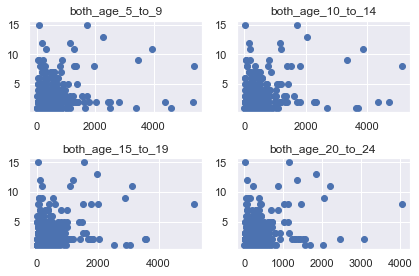

In [10]:
# Both ages
x_both = ['both_age_5_to_9', 'both_age_10_to_14', 'both_age_15_to_19', 'both_age_20_to_24']
subplots(x_both, y)

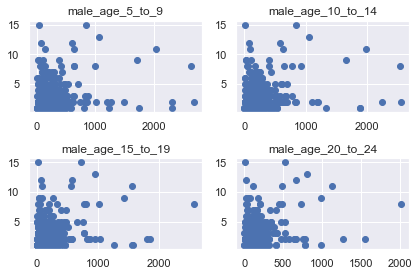

In [11]:
# Male ages
x_male = ['male_age_5_to_9', 'male_age_10_to_14', 'male_age_15_to_19', 'male_age_20_to_24']
subplots(x_male, y)

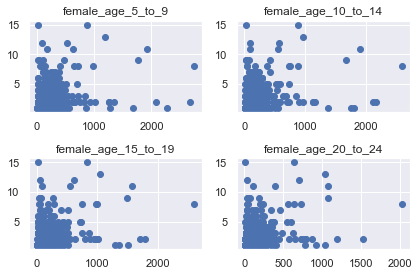

In [12]:
# Female ages
x_female = ['female_age_5_to_9', 'female_age_10_to_14', 'female_age_15_to_19', 'female_age_20_to_24']
subplots(x_female, y)

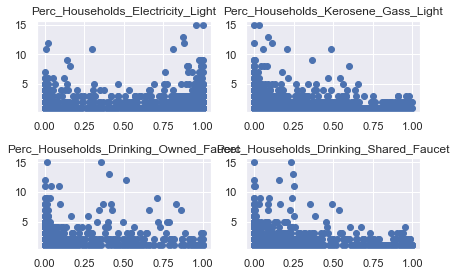

In [13]:
x_sgd = ['Perc_Households_Electricity_Light', 'Perc_Households_Kerosene_Gass_Light', 'Perc_Households_Drinking_Owned_Faucet', 'Perc_Households_Drinking_Shared_Faucet']
subplots(x_sgd, y)

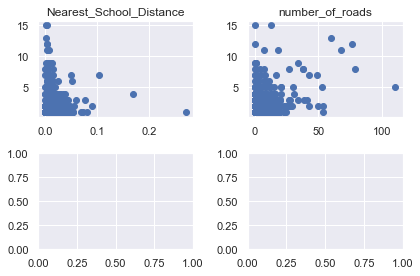

In [14]:
x_roads = ['Nearest_School_Distance', 'number_of_roads']
subplots(x_roads, y)

In [18]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [19]:
print(tf.__version__)

2.4.1


In [103]:
dataset = population_data.copy()
dataset.tail()
dataset = dataset[['No_of_Schools', 'both_age_5_to_9', 'male_age_5_to_9', 'female_age_5_to_9',
           'both_age_10_to_14', 'male_age_10_to_14', 'female_age_10_to_14',
           'both_age_15_to_19', 'male_age_15_to_19', 'female_age_15_to_19',
           'both_age_20_to_24', 'male_age_20_to_24', 'female_age_20_to_24',
           'Perc_Households_Electricity_Light', 'Perc_Households_Kerosene_Gass_Light',
           'Perc_Households_Drinking_Owned_Faucet', 'Perc_Households_Drinking_Shared_Faucet',
           'number_of_roads', 'Nearest_School_Distance']]

In [104]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

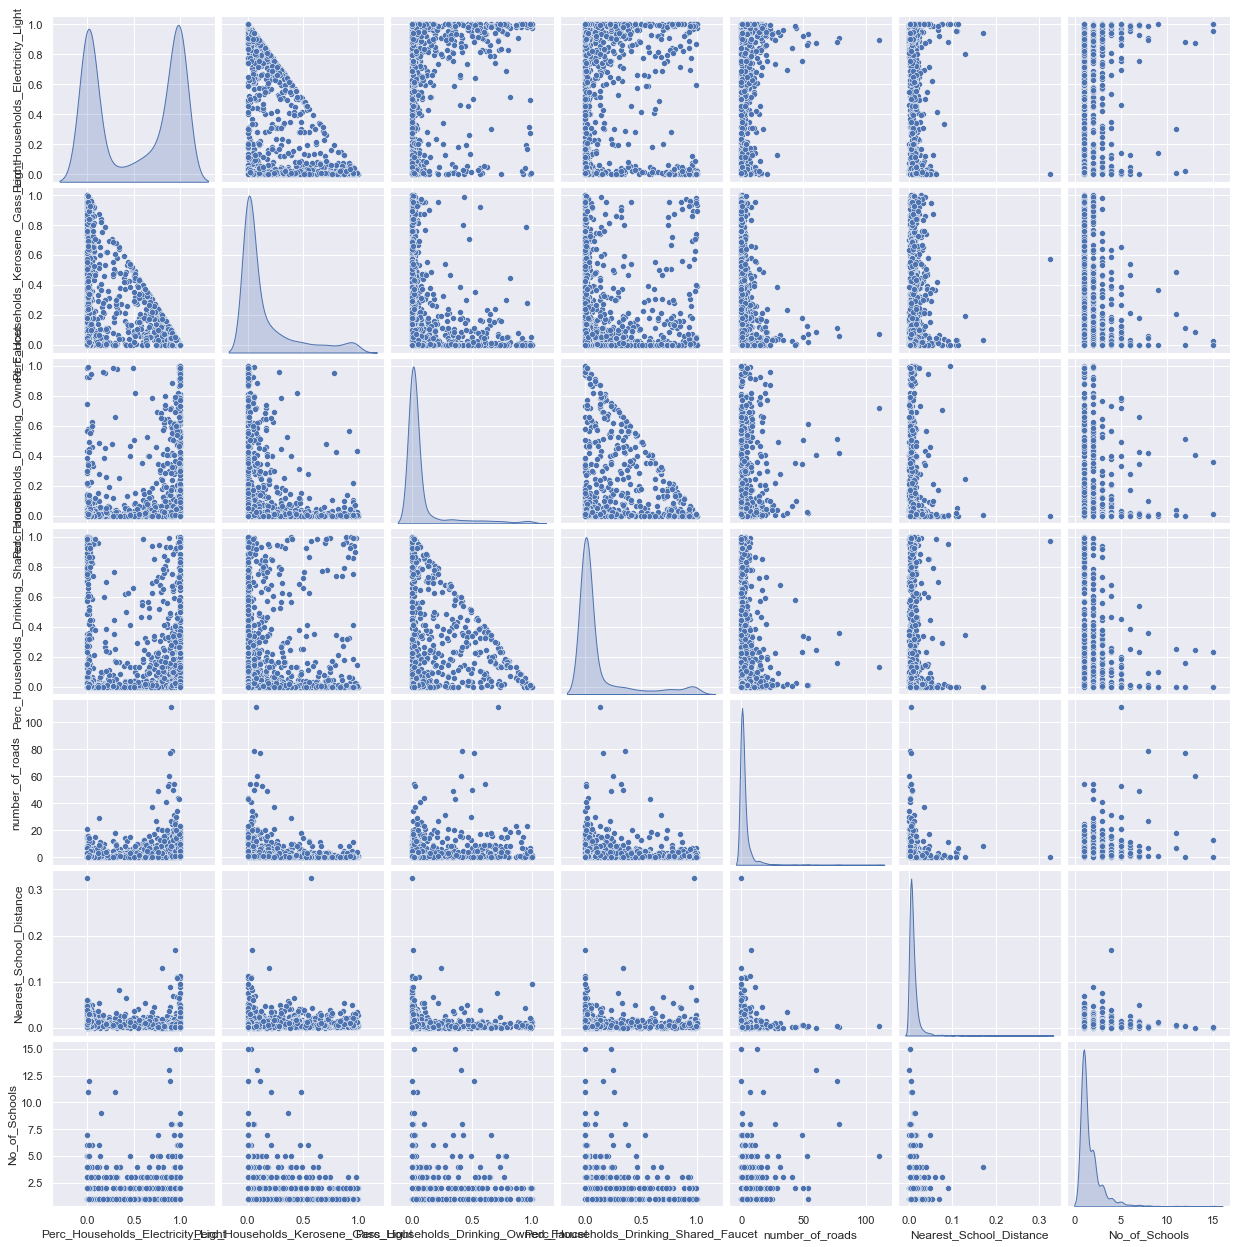

In [105]:
sns.pairplot(train_dataset[['Perc_Households_Electricity_Light', 
                            'Perc_Households_Kerosene_Gass_Light', 
                            'Perc_Households_Drinking_Owned_Faucet', 
                            'Perc_Households_Drinking_Shared_Faucet', 
                            'number_of_roads', 
                            'Nearest_School_Distance', 'No_of_Schools']], diag_kind='kde')

In [106]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('No_of_Schools')
test_labels = test_features.pop('No_of_Schools')

In [107]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
No_of_Schools,1.717478,1.419847
both_age_5_to_9,226.655589,284.519132
male_age_5_to_9,114.207452,144.419562
female_age_5_to_9,112.448137,141.082631
both_age_10_to_14,203.823766,259.683571
male_age_10_to_14,102.621349,132.074022
female_age_10_to_14,101.202417,128.481609
both_age_15_to_19,171.367573,231.695026
male_age_15_to_19,85.041289,115.499338
female_age_15_to_19,86.326284,117.320574


### Normalize variables

In [108]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

### Linear Regression

In [109]:
EPOCHS=10

In [118]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mean_squared_error'])
    return model

In [119]:
model = build_and_compile_model(normalizer)

In [120]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    epochs=EPOCHS
)

Epoch 1/10
50/50 [==============================] - 2s 11ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/10
50/50 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/10
50/50 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/10
29/50 [================>.............] - ETA: 0s - loss: nan - mean_squared_error: nan